## [BCCD Dataset](https://github.com/Shenggan/BCCD_Dataset)
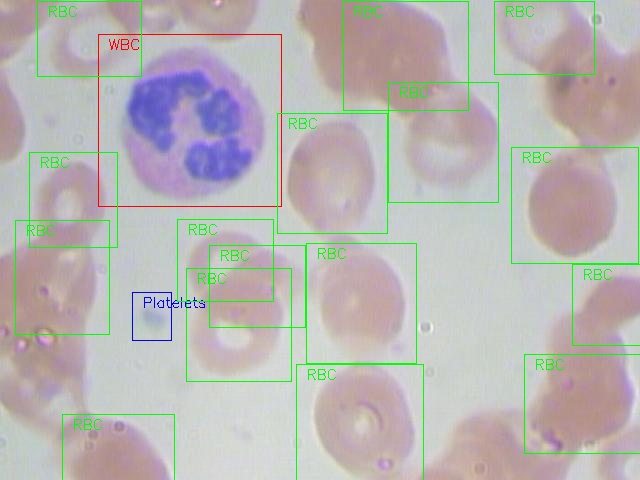

In [ ]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np

In [ ]:
annotations = sorted(glob('/kaggle/input/bccd-dataset/BCCD_Dataset-master/BCCD/Annotations/*.xml'))

df = []
cnt = 0
for file in annotations:
  prev_filename = file.split('/')[-1].split('.')[0] + '.jpg'
  filename = str(cnt) + '.jpg'
  row = []
  parsedXML = ET.parse(file)
  for node in parsedXML.getroot().iter('object'):
    blood_cells = node.find('name').text
    xmin = int(node.find('bndbox/xmin').text)
    xmax = int(node.find('bndbox/xmax').text)
    ymin = int(node.find('bndbox/ymin').text)
    ymax = int(node.find('bndbox/ymax').text)

    row = [prev_filename, filename, blood_cells, xmin, xmax, ymin, ymax]
    df.append(row)
  cnt += 1

data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax'])

data[['prev_filename','filename', 'cell_type', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv('blood_cell_detection.csv', index=False)
data.head(10)

In [ ]:
img_width = 640
img_height = 480

def width(df):
  return int(df.xmax - df.xmin)
def height(df):
  return int(df.ymax - df.ymin)
def x_center(df):
  return int(df.xmin + (df.width/2))
def y_center(df):
  return int(df.ymin + (df.height/2))
def w_norm(df):
  return df/img_width
def h_norm(df):
  return df/img_height

df = pd.read_csv('blood_cell_detection.csv')

le = preprocessing.LabelEncoder()
le.fit(df['cell_type'])
print(le.classes_)
labels = le.transform(df['cell_type'])
df['labels'] = labels

df['width'] = df.apply(width, axis=1)
df['height'] = df.apply(height, axis=1)

df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df['x_center'].apply(w_norm)
df['width_norm'] = df['width'].apply(w_norm)

df['y_center_norm'] = df['y_center'].apply(h_norm)
df['height_norm'] = df['height'].apply(h_norm)

df.head(10)

## Repro [YOLOv5](https://github.com/ultralytics/yolov5)

In [ ]:
!git clone https://github.com/rkuo2000/yolov5

%cd yolov5

In [ ]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.1, random_state=13, shuffle=True)
print(df_train.shape, df_valid.shape)

#os.mkdir('data/')
os.mkdir('data/images/')
os.mkdir('data/images/train/')
os.mkdir('data/images/valid/')

os.mkdir('data/labels/')
os.mkdir('data/labels/train/')
os.mkdir('data/labels/valid/')

def segregate_data(df, img_path, label_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.prev_filename.split('.')[0])+".txt")
    # Save the .img & .txt files to the corresponding train and validation folders
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.prev_filename), os.path.join(train_img_path,row.prev_filename))
 
## Apply function ## 
src_img_path = "/kaggle/input/bccd-dataset/BCCD_Dataset-master/BCCD/JPEGImages/"
src_label_path = "/kaggle/input/bccd-dataset/BCCD_Dataset-master/BCCD/Annotations/"

train_img_path = "data/images/train"
train_label_path = "data/labels/train"

valid_img_path = "data/images/valid"
valid_label_path = "data/labels/valid"

segregate_data(df_train, src_img_path, src_label_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, src_label_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('data/images/train')))
print("No. of Training labels", len(os.listdir('data/labels/train')))

print("No. of valid images", len(os.listdir('data/images/valid')))
print("No. of valid labels", len(os.listdir('data/labels/valid')))

In [ ]:
!echo "train: data/images/train\n" > data/bccd.yaml
!echo "val:   data/images/valid\n" >> data/bccd.yaml
!echo "nc : 3\n" >> data/bccd.yaml
!echo "names: ['Platelets', 'RBC', 'WBC']\n" >> data/bccd.yaml

!cat data/bccd.yaml

## Train YOLOv5

In [ ]:
!python train.py --img 640 --batch 8 --epochs 100 --data data/bccd.yaml --cfg models/yolov5s.yaml --name BCCM

## YOLOv5 Detect

In [ ]:
# detect a folder
#!python detect.py --source data/images/valid/ 
#  --weights 'weights/best_yolov5_BCCM.pt'
#  --output 'inference/output'

In [ ]:
!python detect.py --weights yolov5s.pt --img-size 416 --conf 0.4 --source data/images/valid/BloodImage_00000.jpg
Image(filename='inference/output/BloodImage_00000.jpg', width=600)